PyTorchViz examples
==========

In [1]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

## Visualize gradients of simple MLP

The method below is for building directed graphs of PyTorch operations, built during forward propagation and showing which operations will be called on backward. It omits subgraphs which do not require gradients.

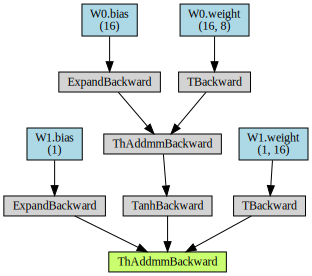

In [2]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))

### torch.jit.trace

An alternative to the above is `torch.jit.trace`, which gives more information about operations, and shows all operations performed during forward

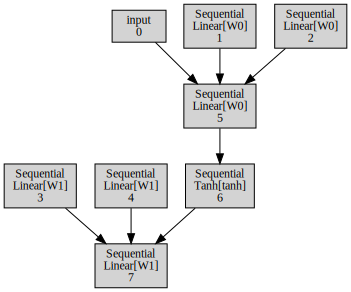

In [3]:
with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
make_dot_from_trace(trace)

## Double Backpropagation

Implements "Double Backpropagation" from [Drucker and Lecun](http://yann.lecun.com/exdb/publis/pdf/drucker-lecun-92.pdf). The idea is to minimize the loss:

$$f(x, \theta) = f(x, \theta) + g(\frac{\partial f(x, \theta)}{\partial x})$$

where $x$ and $\theta$ are input and parameter vectors, $f(x, \theta)$ is the original loss function, and $g$ is a function of gradient w.r.t. input.

This is used in [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) and [Attention Transfer](https://arxiv.org/abs/1612.03928).

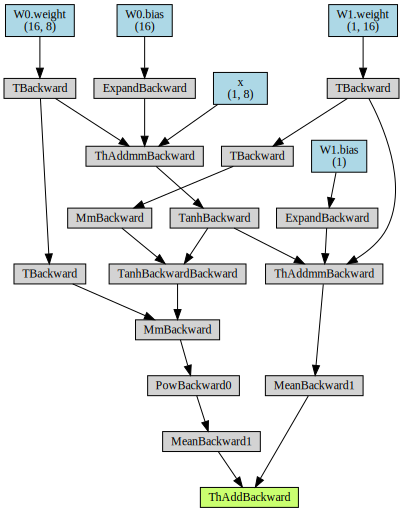

In [4]:
x = torch.randn(1,8).requires_grad_(True)

def double_backprop(inputs, net):
    y = net(x).mean()
    grad,  = torch.autograd.grad(y, x, create_graph=True, retain_graph=True)
    return grad.pow(2).mean() + y

make_dot(double_backprop(x, model), params=dict(list(model.named_parameters()) + [('x', x)]))

## AlexNet

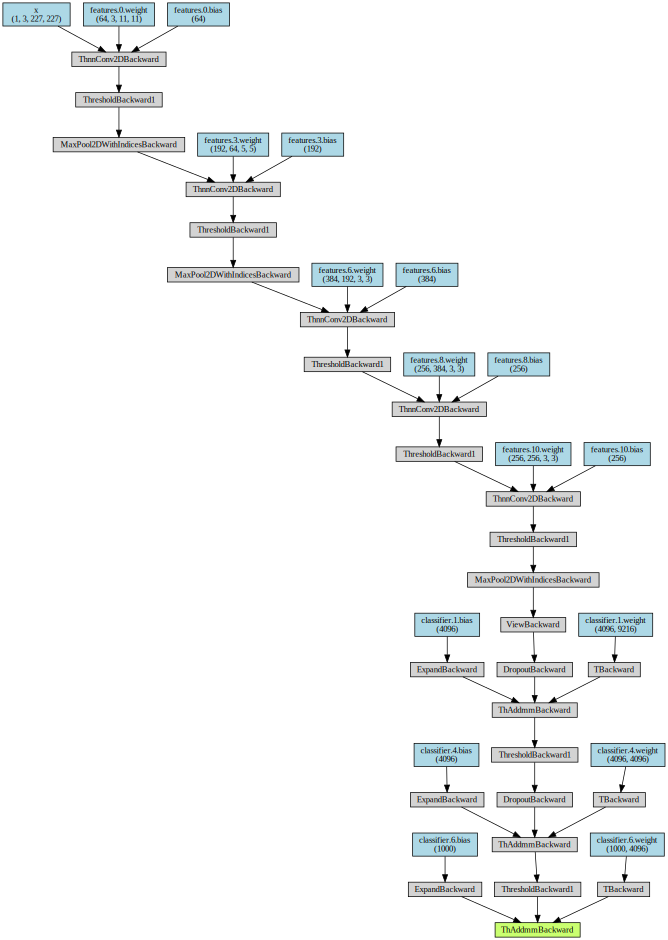

In [5]:
from torchvision.models import AlexNet

model = AlexNet()

x = torch.randn(1, 3, 227, 227).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

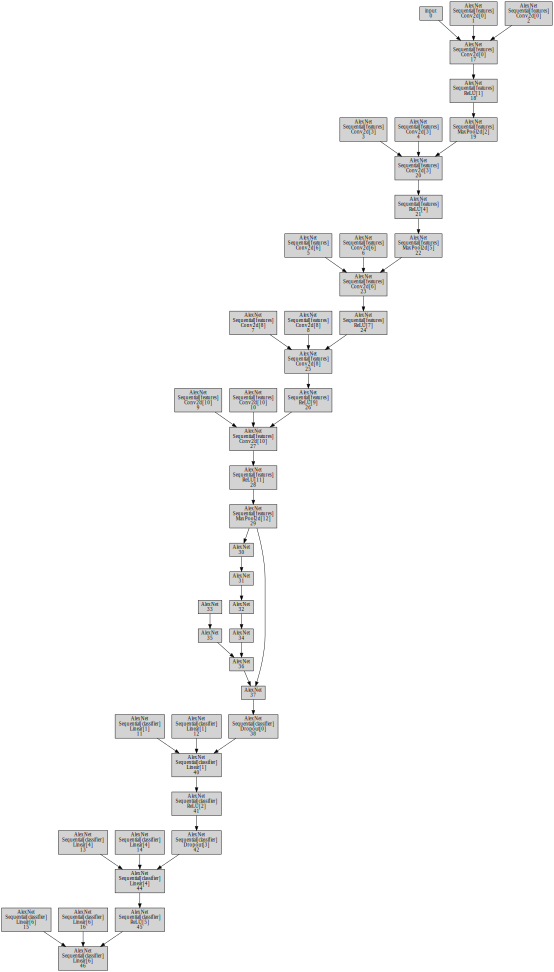

In [6]:
with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
make_dot_from_trace(trace)

And AlexNet double backprop for fun:

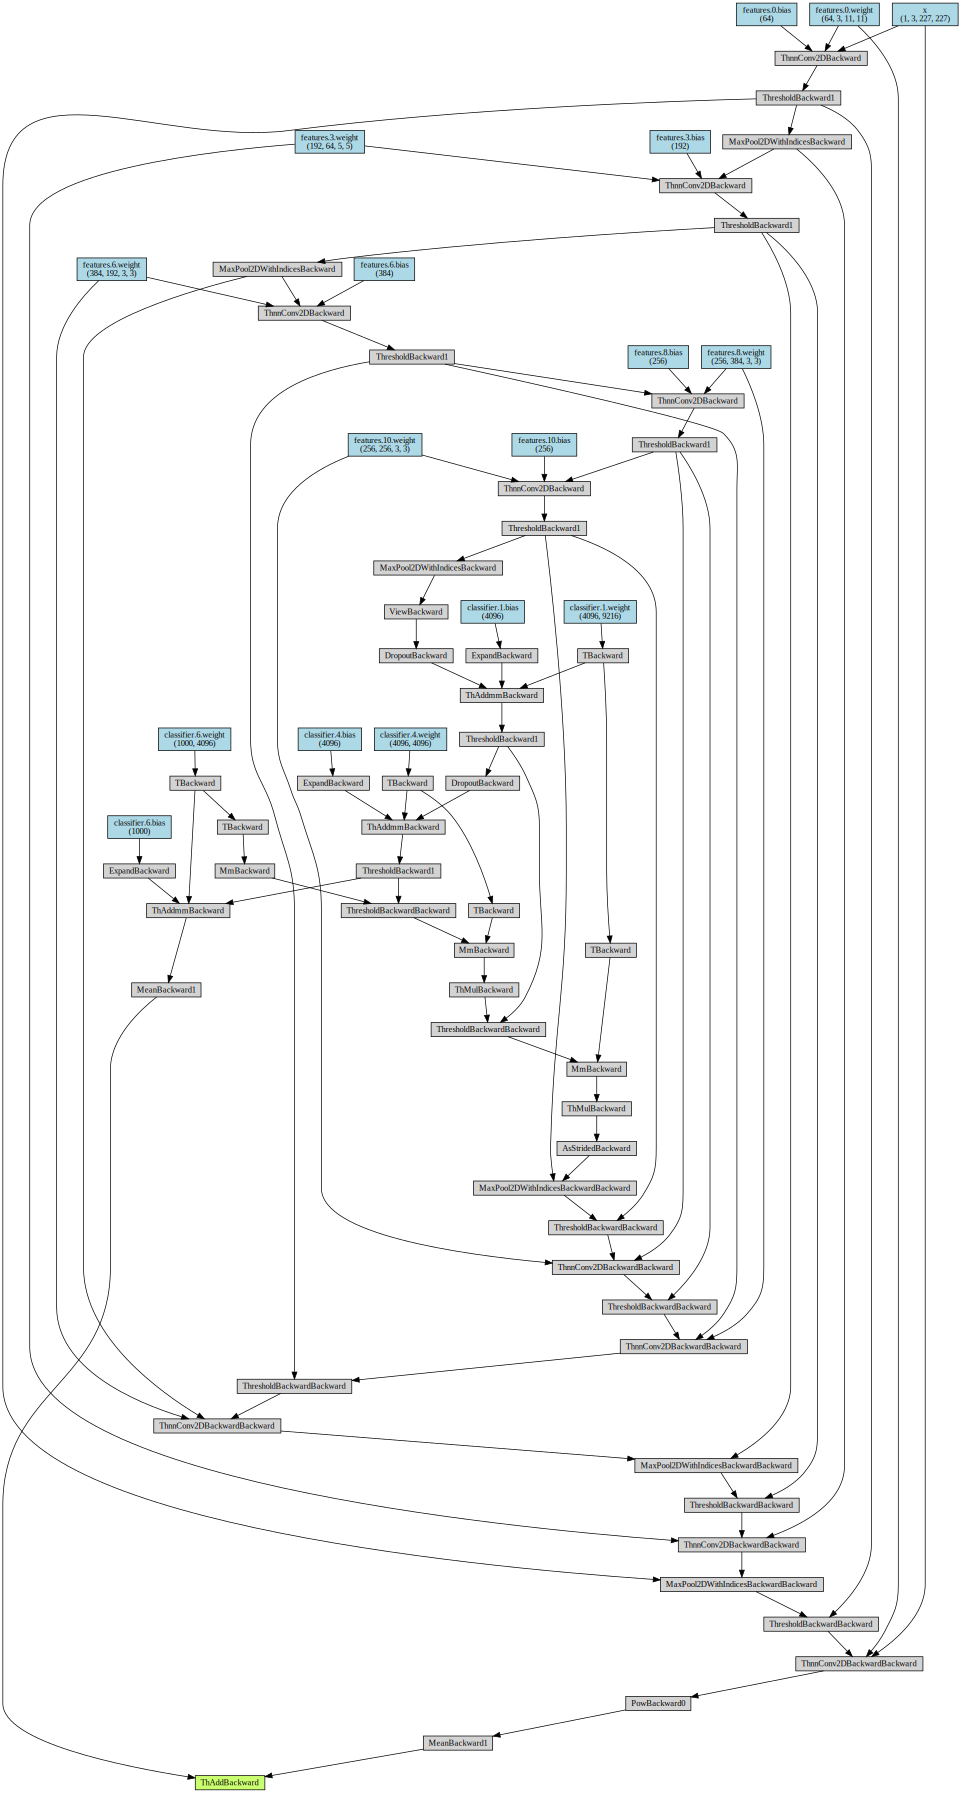

In [7]:
make_dot(double_backprop(x, model), params=dict(list(model.named_parameters()) + [('x', x)]))

## LSTM cell

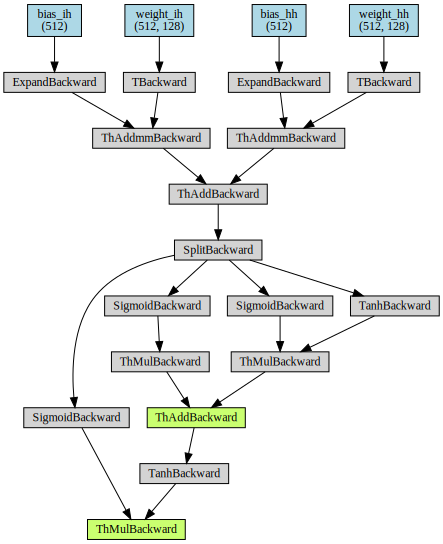

In [8]:
lstm_cell = nn.LSTMCell(128, 128)
x = torch.randn(1, 128)
make_dot(lstm_cell(x), params=dict(list(lstm_cell.named_parameters())))